In [1]:
import numpy as np
import math
import pandas as pd
import seaborn as sns
import itertools
import matplotlib
import matplotlib.pyplot as plt
import scipy.io
from scipy.stats import qmc

discrepancy of sample: 0.0028297468020870298. seed: 10
You have 7 number of input variables and a total of 266 number of cases.
Shape of your input sample array: (266, 7)


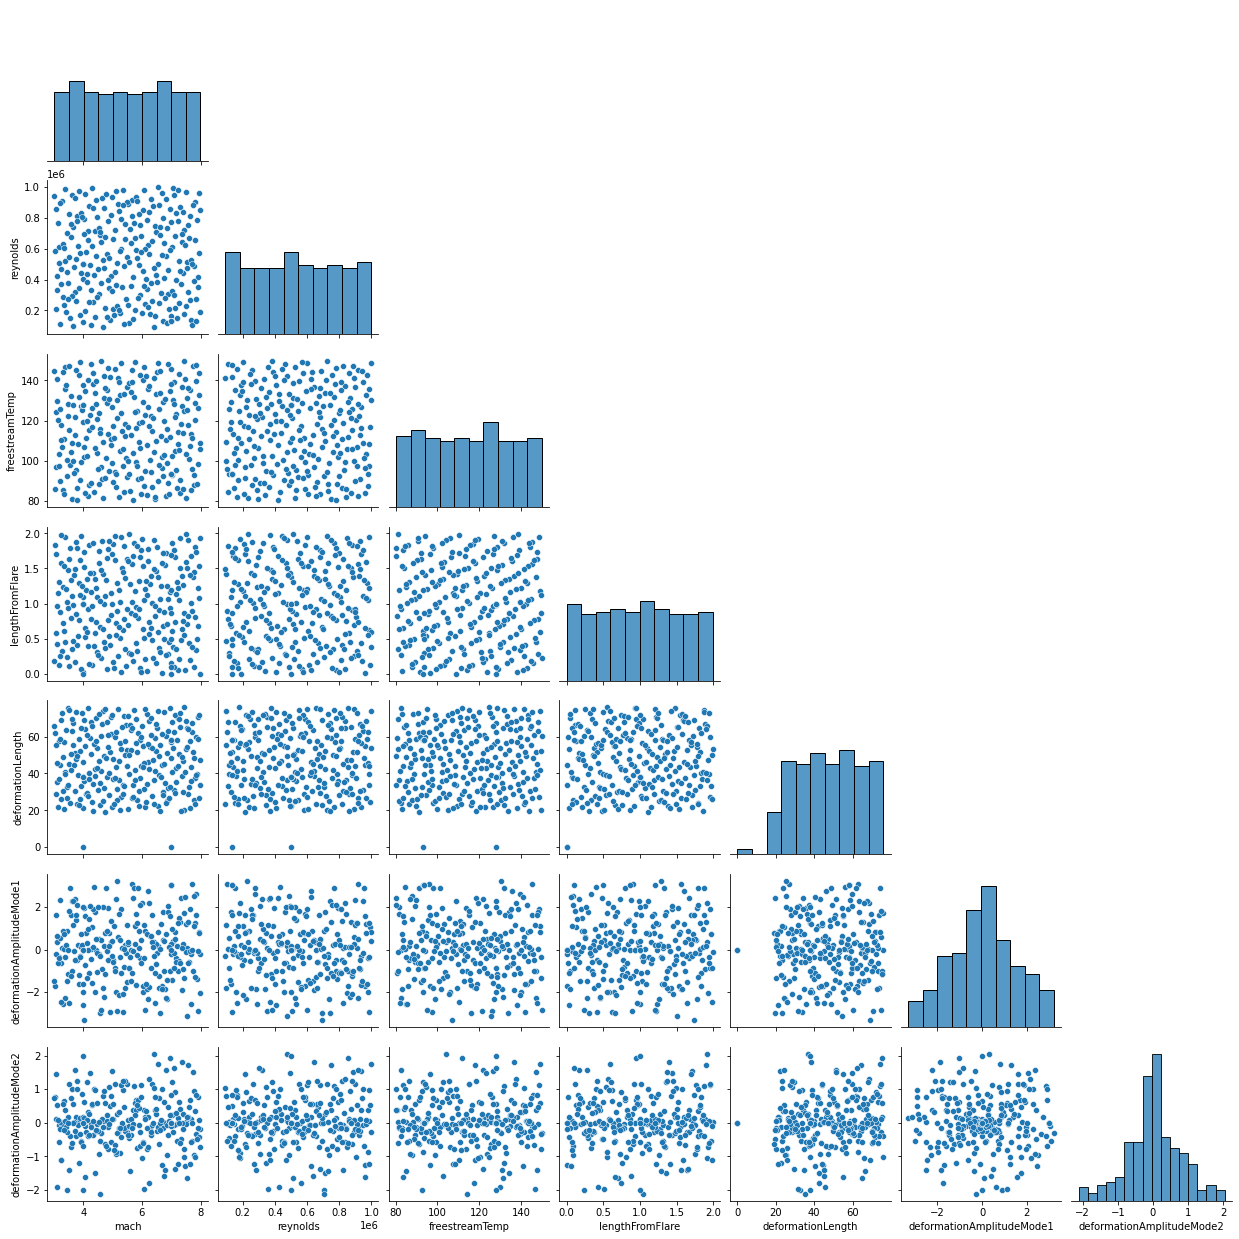

In [108]:
samplerChoice = 'Halton' # choose Halton or Sobol
seed = 10 # random seed, used for repeatability 
desiredTotalCFDCases = 256 # should be power of two if using Sobol 
numContinuedSamplePoints = 10 # select number of additional points to sample
continueSample = False # choose whether to continue previous sample
hyperellipsoidSample = True # choose whether to use hyperellipsoid sampling

# put input param names in a list
inputParamNames = [
    'mach',
    'reynolds',
    'freestreamTemp',
    'lengthFromFlare',
    'deformationLength',
    'deformationAmplitudeMode1',
    'deformationAmplitudeMode2',
]

#set upper and lower bounds. index location correpsonds to above list. 
l_bounds = [3, 9e4, 80, 0, 19, -3.3, -2.2]
u_bounds = [8, 1e6, 150, 2, 76, 3.3, 2.2]

# select the variables that will be sampled with hyperellipsoid sampling 
hyperellipsoidSampleList = [
    'deformationAmplitudeMode1',
    'deformationAmplitudeMode2',
]

# find index for variables that will be hyperellipsoid sampled 
hyperellipsoidSampleLoc = [inputParamNames.index(item) for item in hyperellipsoidSampleList]

# add one, since we're using the first index location for the f(r) h.e. scaling factor (called U in this code)
hyperellipsoidSampleLoc = np.asarray([item+1 for item in hyperellipsoidSampleLoc])

# define input param dimensions 
dimensions = len(l_bounds)

# add one to the dimension for hyperellipsoid sampling. 
if hyperellipsoidSample:
    dimensions += 1
    l_bounds.append(l_bounds[-2])
    u_bounds.append(u_bounds[-2])

m = math.log2(desiredTotalCFDCases)
m = math.ceil(m)

printDict = {
    True: 'HAVE',
    False: 'HAVE NOT'
}

def is_power_of_two(number : int) -> bool:
    while number != 1:
        if number % 2:
            return False
        number /= 2
    return True

powerOfTwoBool = is_power_of_two(number=desiredTotalCFDCases) # creates boolean if the number of cases creates a power of 2 for the low discrepancy sequence  

if samplerChoice == 'Sobol':
    print(f'You {printDict[powerOfTwoBool]} selected a power of 2 for number of cases.') 
    if not powerOfTwoBool:
        print(f'Based on your desired number of CFD cases, you\'ll need to run {(2**m)} cases to safely use LDS. \nTo run less cases, you could instead run {(2**(m-1))} CFD cases\nTo run more cases, you could instead run {(2**(m+1))} CFD cases\n')
    sampler = qmc.Sobol(d=dimensions, scramble=False,seed = seed)
    sample = sampler.random_base2(m=m)
    print(f'discrepancy of sample: {qmc.discrepancy(sample)}. seed: {seed}')


    sample.shape
if samplerChoice == 'Halton':
    sampler = qmc.Halton(d=dimensions, scramble=True,seed = seed)
    # _ = sampler.fast_forward(2**(m))
    # sample_continued = sampler.random(n=5)
    sample = sampler.random(n=desiredTotalCFDCases)
    print(f'discrepancy of sample: {qmc.discrepancy(sample)}. seed: {seed}')


if not hyperellipsoidSample:
    sample = qmc.scale(sample, l_bounds, u_bounds)
else:
    #####################################
    ###### Hyperellipsoid sampling ######
    #####################################
 
    idxMode1 = inputParamNames.index('deformationAmplitudeMode1') 
    idxMode2 = idxMode1+1
    scaledSample = qmc.scale(sample[:,:idxMode1], l_bounds[:idxMode1], u_bounds[:idxMode1])
    Uexponent = 1/0.9

    x1= qmc.scale(sample[:,idxMode1].reshape(-1,1), l_bounds[idxMode1], u_bounds[idxMode1])
    x2= qmc.scale(sample[:,idxMode2].reshape(-1,1), l_bounds[idxMode2], u_bounds[idxMode2])

    U1=((sample[:,-1]**Uexponent)*u_bounds[idxMode1]).reshape(-1,1)
    U2=((sample[:,-1]**Uexponent)*u_bounds[idxMode2]).reshape(-1,1)

    y1=(x1*U1)/((x1**2+x2**2)**0.5)
    y2=(x2*U2)/((x1**2+x2**2)**0.5)

    # plt.scatter(y1,y2,s=2)
    # print(np.min(y1), np.max(y1))
    # print(np.min(y2), np.max(y2))

    sample = np.hstack((scaledSample,y1,y2))

    # an attempt to make this more robust. Left hardcoded instead. 
    ############# | | | ################
    ############# | | | ################
    ############# V V V ################

    # exponent = 1/len(hyperellipsoidSampleList)
    # exponent = 1
    # U = sample[:,-1]**(exponent)*3-(3/2)
    
    # originalSampleList = []
    # transformedSampleList = []
    # transformationDenom = np.sum(sample[:,hyperellipsoidSampleLoc]**2,axis=1)**0.5
    # for idx in hyperellipsoidSampleLoc: 
    #     originalSample = sample[:,idx]
    #     transfomedSample = (sample[:,idx]*U)/transformationDenom

    #     originalSampleList.append(originalSample)
    #     transformedSampleList.append(transfomedSample)

    # # #transformed coords 
    # # y1=x1.*U./sqrt(x1.^2+x2.^2+x3.^2);
    # # y2=x2.*U./sqrt(x1.^2+x2.^2+x3.^2);
    # # y3=x3.*U./sqrt(x1.^2+x2.^2+x3.^2);


new_data=np.array([
    [4, 5e5, 128, 1, 38, 0, 2],
    [4, 5e5, 128, 1, 38, 2, 0],
    [4, 5e5, 128, 1, 38, 0, -2],
    [4, 5e5, 128, 1, 38, -2, 0],
    [4, 5e5, 128, 0, 0, 0, 0],
    [7, 133000, 93.3, 0, 0, 0, 0],
    [7, 133000, 93.3, 1.2, 58, 3, 0],
    [7, 133000, 93.5, 0.86, 58, 3, 0],
    [7, 133000, 93.5, 0.5, 58, 3, 0],
    [7, 133000, 93.5, 0.1, 58, 3, 0]
    ])


sampleArray = np.concatenate((sample,new_data))

print(f'You have {sampleArray.shape[1]} number of input variables and a total of {sampleArray.shape[0]} number of cases.')
print(f'Shape of your input sample array: {sampleArray.shape}')

df = pd.DataFrame(data = sampleArray, columns = inputParamNames)
df.to_csv('./inputVariables.csv')
sns.pairplot(df, corner=True)

# Re-sampling

In [ ]:

sample = qmc.scale(sample, l_bounds, u_bounds)

df = pd.DataFrame(data = sample)
sns.pairplot(df, corner=True)

if continueSample:
    _ = sampler.fast_forward(5)
    sample_continued = sampler.random(n=5)
    sample_continued
# for length in np.arange(5,8):
length = 4
sampler = qmc.Halton(d=length, scramble=True,seed = seed)
# _ = sampler.fast_forward(2**(m))
# sample_continued = sampler.random(n=5)
sample = sampler.random(n=10)
print(f'discrepancy of sample: {qmc.discrepancy(sample)}. seed: {seed}')

# sample = qmc.scale(sample, l_bounds, u_bounds)
# sample.shape
# df = pd.DataFrame(data = sample)
# sns.pairplot(df, corner=True)

In [ ]:
for length in np.arange(5,8):
    sampler = qmc.Sobol(d=length, scramble=True,seed = seed)
    _ = sampler.fast_forward(2**(m))
    # sample_continued = sampler.random(n=5)
    sample = sampler.random_base2(m=m)
    print(f'discrepancy of sample: {qmc.discrepancy(sample)}. seed: {seed}')

    # sample = qmc.scale(sample, l_bounds, u_bounds)
    sample.shape
    df = pd.DataFrame(data = sample)
    sns.pairplot(df, corner=True)


# sampler = qmc.Sobol(d=len(l_bounds)+1, scramble=False,seed = seed)
# sample = sampler.random_base2(m=m)
# print(f'discrepancy of sample: {qmc.discrepancy(sample)}. seed: {seed}')

# # sample = qmc.scale(sample, l_bounds, u_bounds)
# sample.shape
# df = pd.DataFrame(data = sample)
# sns.pairplot(df, corner=True)

# Archive

discrepancy of sample: 1.8436184791914556e-05. seed: 10
-2.9610682896174434 2.943151218386593
-1.9784881713549942 1.927785823285302


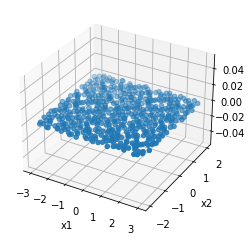

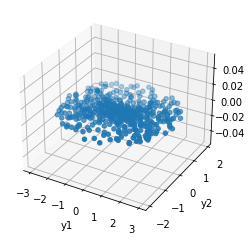

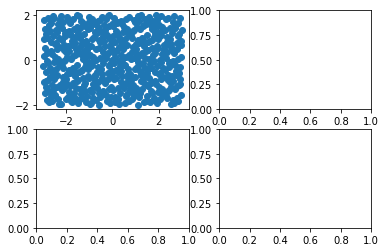

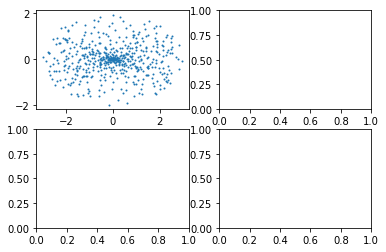

In [82]:
sampler = qmc.Halton(d=3, scramble=True,seed = seed)
sample = sampler.random(n=2**9)
print(f'discrepancy of sample: {qmc.discrepancy(sample)}. seed: {seed}')

scalingFactor = 2
subtractFactor = scalingFactor/2
# subtractFactor = 1

x1=((sample[:,0])*scalingFactor)-subtractFactor
x2=((sample[:,1])*scalingFactor)-subtractFactor
# x3=((sample[:,2])*scalingFactor)-subtractFactor

x1= qmc.scale(sample[:,0].reshape(-1,1), -3, 3)
x2= qmc.scale(sample[:,1].reshape(-1,1), -2, 2)
# x3= qmc.scale(sample[:,2].reshape(-1,1), -3, 3)

# plt.scatter(x1,x2)

U1=((sample[:,2]**(1/0.9))*3).reshape(-1,1)
U2=((sample[:,2]**(1/0.9))*2).reshape(-1,1)

y1=(x1*U1)/((x1**2+x2**2)**0.5)
y2=(x2*U2)/((x1**2+x2**2)**0.5)
# y3=(x3*U)/((x1**2+x2**2+x3**2)**0.5)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.set_xlabel('x1')
ax.set_ylabel('x2')
# ax.set_zlabel('x3')

ax.scatter(x1,x2)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.set_xlabel('y1')
ax.set_ylabel('y2')
# ax.set_zlabel('y3')

ax.scatter(y1,y2)

fig, axs = plt.subplots(nrows=2,ncols=2)
axs[0,0].scatter(x1,x2)
# axs[0,1].scatter(x2,x3)
# axs[1,0].scatter(x1,x3)

markersize = 1
fig, axs = plt.subplots(nrows=2,ncols=2)
axs[0,0].scatter(y1,y2,s=markersize)
# axs[0,1].scatter(y2,y3,s=markersize)
# axs[1,0].scatter(y1,y3,s=markersize)

print(np.min(y1), np.max(y1))
print(np.min(y2), np.max(y2))
# print(np.min(y3), np.max(y3))

discrepancy of sample: 5.137773159447079e-05. seed: 10
-2.8844071719686606 2.8767136207573256
-2.631282104520673 2.4832573692439803
-2.7163327946660614 2.970433568103061


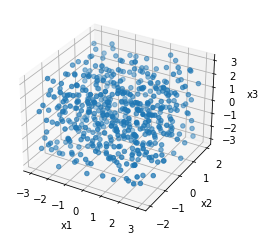

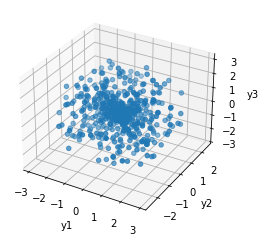

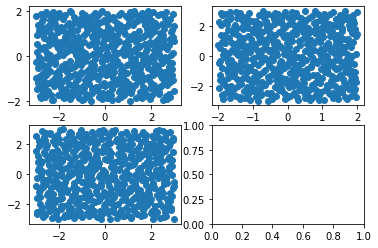

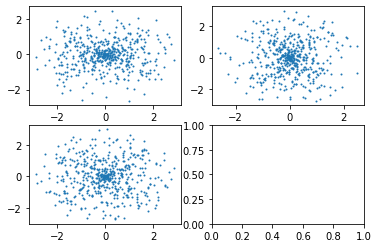

In [75]:
sampler = qmc.Halton(d=4, scramble=True,seed = seed)
sample = sampler.random(n=2**9)
print(f'discrepancy of sample: {qmc.discrepancy(sample)}. seed: {seed}')

scalingFactor = 3
subtractFactor = scalingFactor/2
# subtractFactor = 1

x1=((sample[:,0])*scalingFactor)-subtractFactor
x2=((sample[:,1])*scalingFactor)-subtractFactor
x3=((sample[:,2])*scalingFactor)-subtractFactor

x1= qmc.scale(sample[:,0].reshape(-1,1), -3, 3)
x2= qmc.scale(sample[:,1].reshape(-1,1), -2, 2)
x3= qmc.scale(sample[:,2].reshape(-1,1), -3, 3)

# plt.scatter(x1,x2)

U=((sample[:,3]**(1/1))*scalingFactor).reshape(-1,1)

y1=(x1*U)/((x1**2+x2**2+x3**2)**0.5)
y2=(x2*U)/((x1**2+x2**2+x3**2)**0.5)
y3=(x3*U)/((x1**2+x2**2+x3**2)**0.5)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')

ax.scatter(x1,x2,x3)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.set_xlabel('y1')
ax.set_ylabel('y2')
ax.set_zlabel('y3')

ax.scatter(y1,y2,y3)

fig, axs = plt.subplots(nrows=2,ncols=2)
axs[0,0].scatter(x1,x2)
axs[0,1].scatter(x2,x3)
axs[1,0].scatter(x1,x3)

markersize = 1
fig, axs = plt.subplots(nrows=2,ncols=2)
axs[0,0].scatter(y1,y2,s=markersize)
axs[0,1].scatter(y2,y3,s=markersize)
axs[1,0].scatter(y1,y3,s=markersize)

print(np.min(y1), np.max(y1))
print(np.min(y2), np.max(y2))
print(np.min(y3), np.max(y3))

In [ ]:
#untransformed coords 
# x1=(Y0(:,1)*2-1)*1;
# x2=(Y0(:,2)*2-1)*1;
# x3=(Y0(:,3)*2-1)*1;

#scaling factor 
# U=Y0(:,4).^(1/3)*2; %U=Y0(:,4).^4*10 adjusts clustering.  10 is the radius
exponent = 1/len(hyperellipsoidSampleList)
exponent = 1/3
U = sample[:,0]**(exponent)

originalSampleList = []
transformedSampleList = []
transformationDenom = np.sum(sample[:,hyperellipsoidSampleLoc]**2,axis=1)**0.5
for idx in hyperellipsoidSampleLoc: 
    originalSample = sample[:,idx]
    transfomedSample = (sample[:,idx]*U)/transformationDenom

    originalSampleList.append(originalSample)
    transformedSampleList.append(transfomedSample)

# #transformed coords 
# y1=x1.*U./sqrt(x1.^2+x2.^2+x3.^2);
# y2=x2.*U./sqrt(x1.^2+x2.^2+x3.^2);
# y3=x3.*U./sqrt(x1.^2+x2.^2+x3.^2);

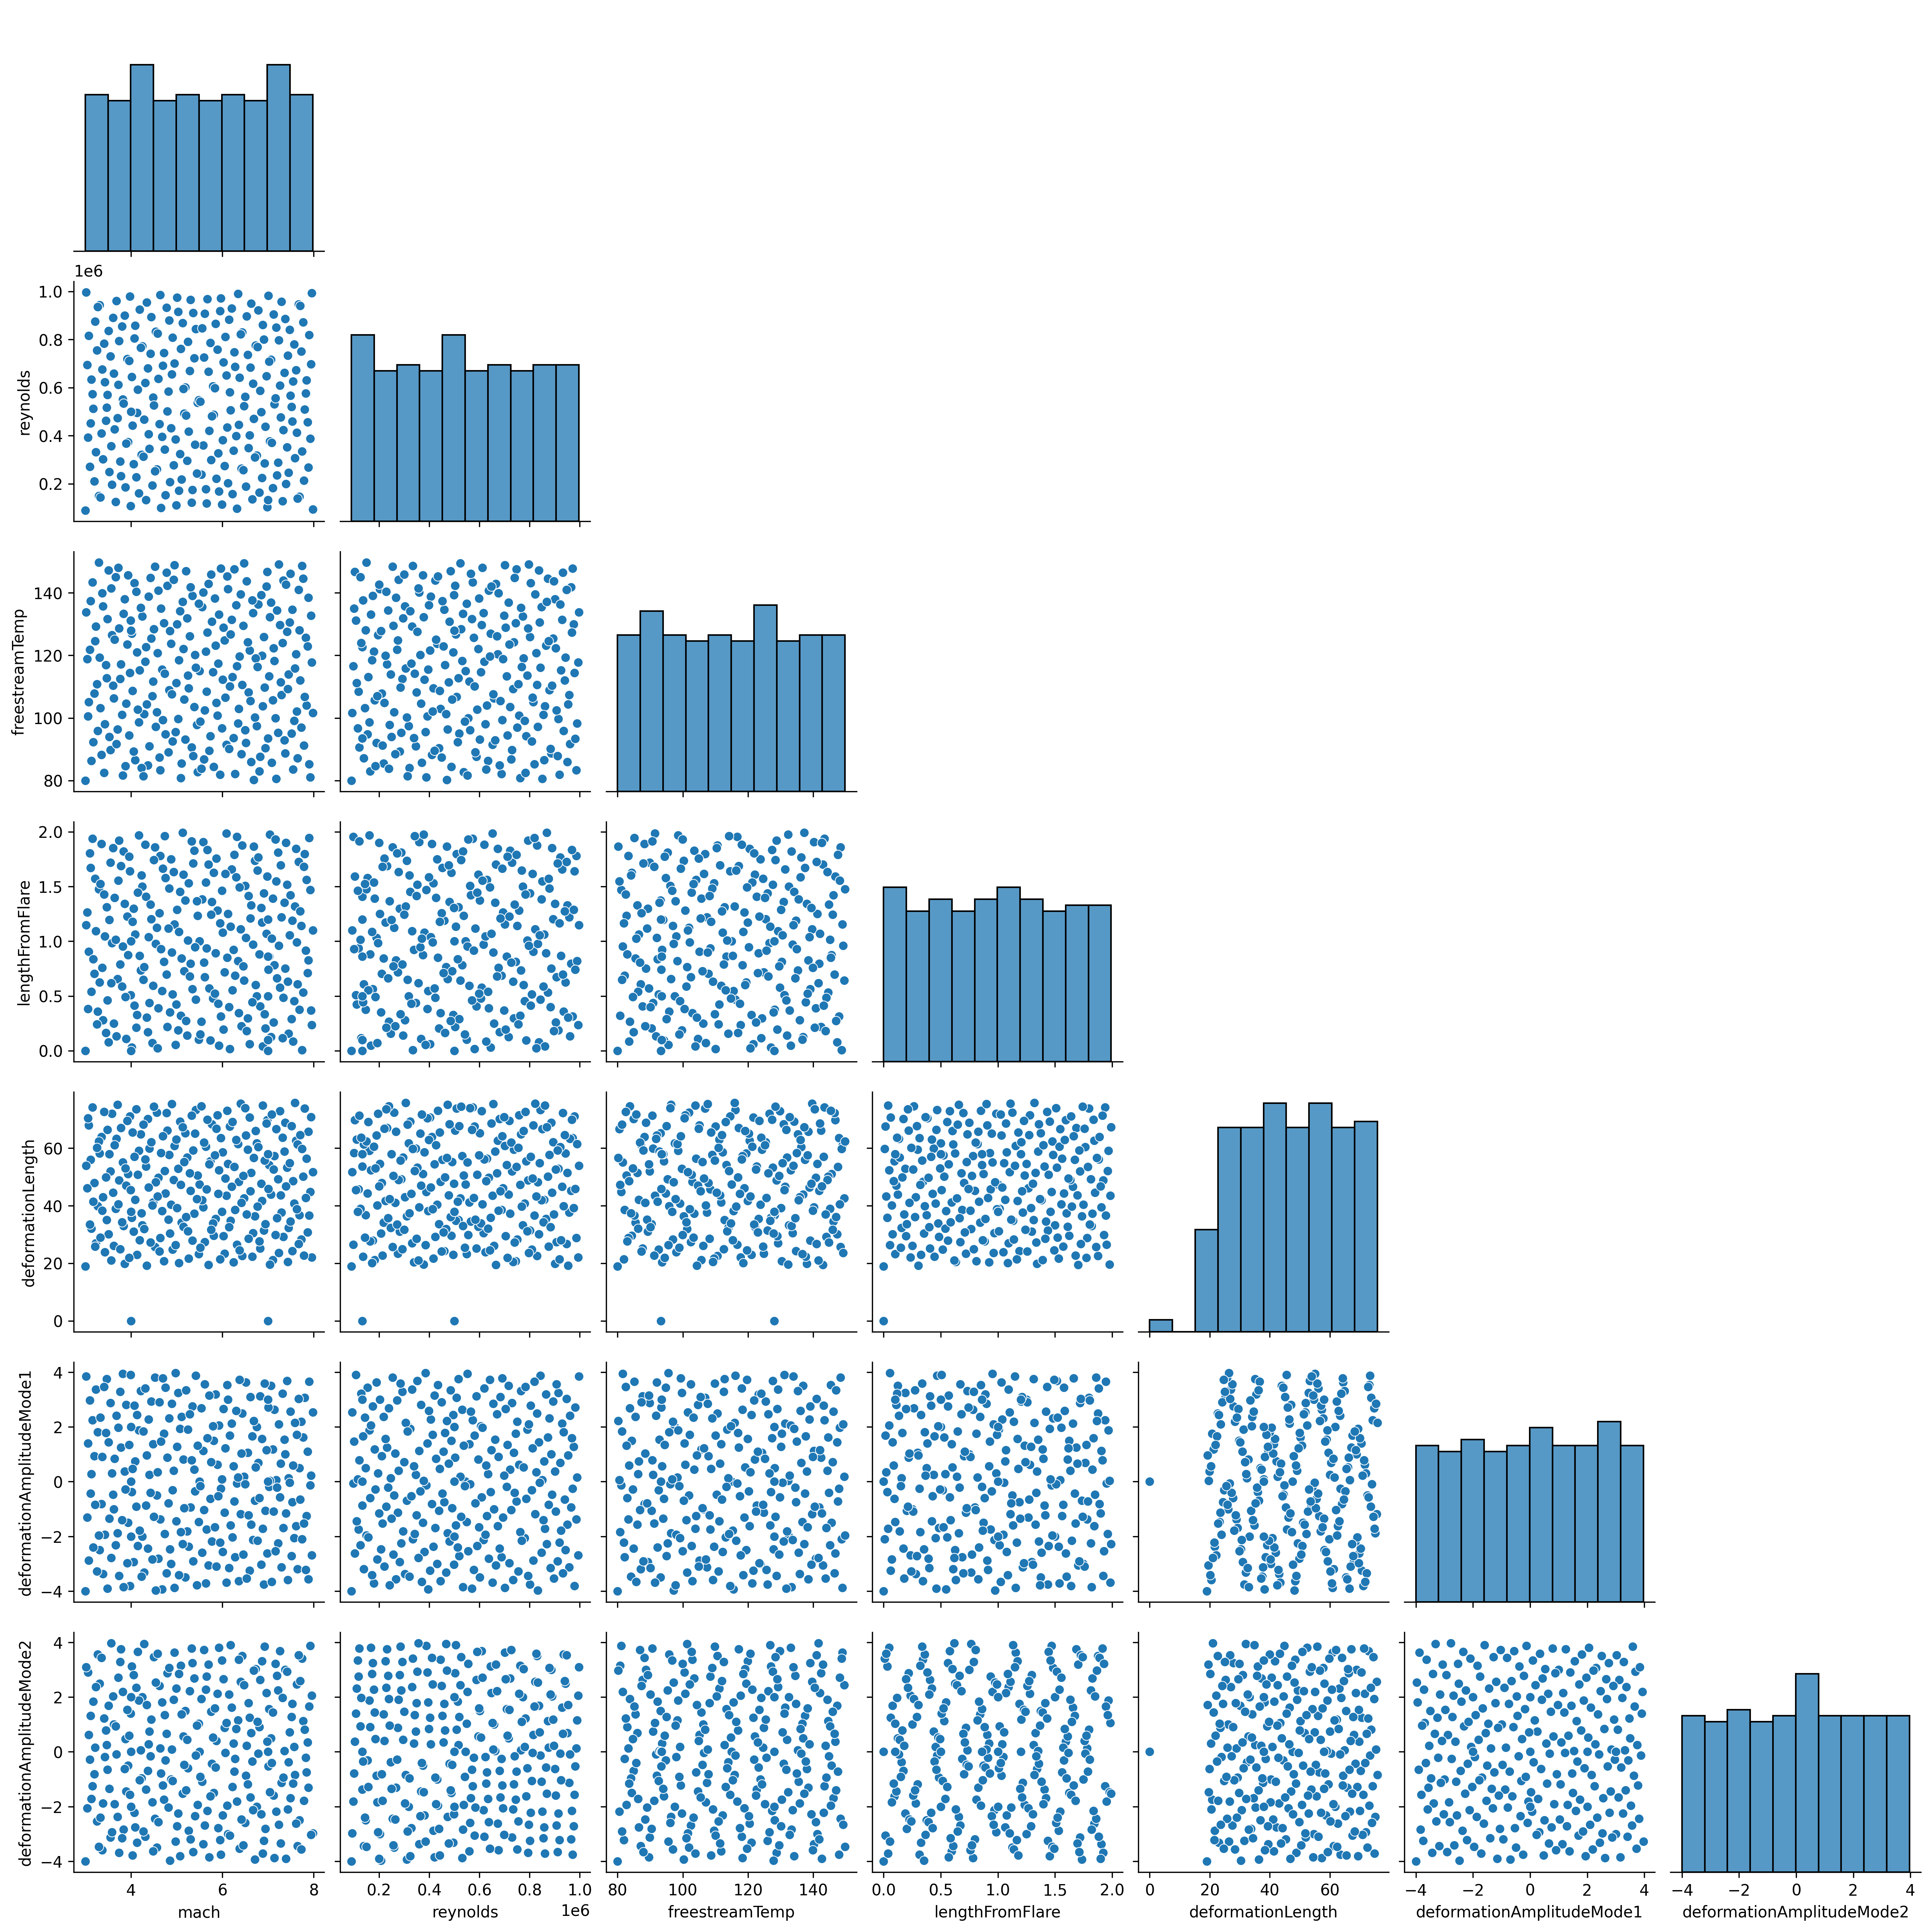

In [8]:
# locationFromFlareDF = pd.DataFrame(data = sampleArray[:,locationOfLengthFromFlare])
# sns.histplot(locationFromFlareDF)
# sns.set(font_scale=1)
selectedVariables = inputParamNames

# columnRenameDict = {
#     'mach': 'Mach',
#     'reynolds': 'Reynolds Number',
#     'deformationAmplitude': 'Deformation Amplitude',
#     'deformationLength': 'Deformation Length'
# }

df_new = df[selectedVariables]
# df_new = df_new.rename(columns=columnRenameDict)
sns.pairplot(df_new, corner=True)

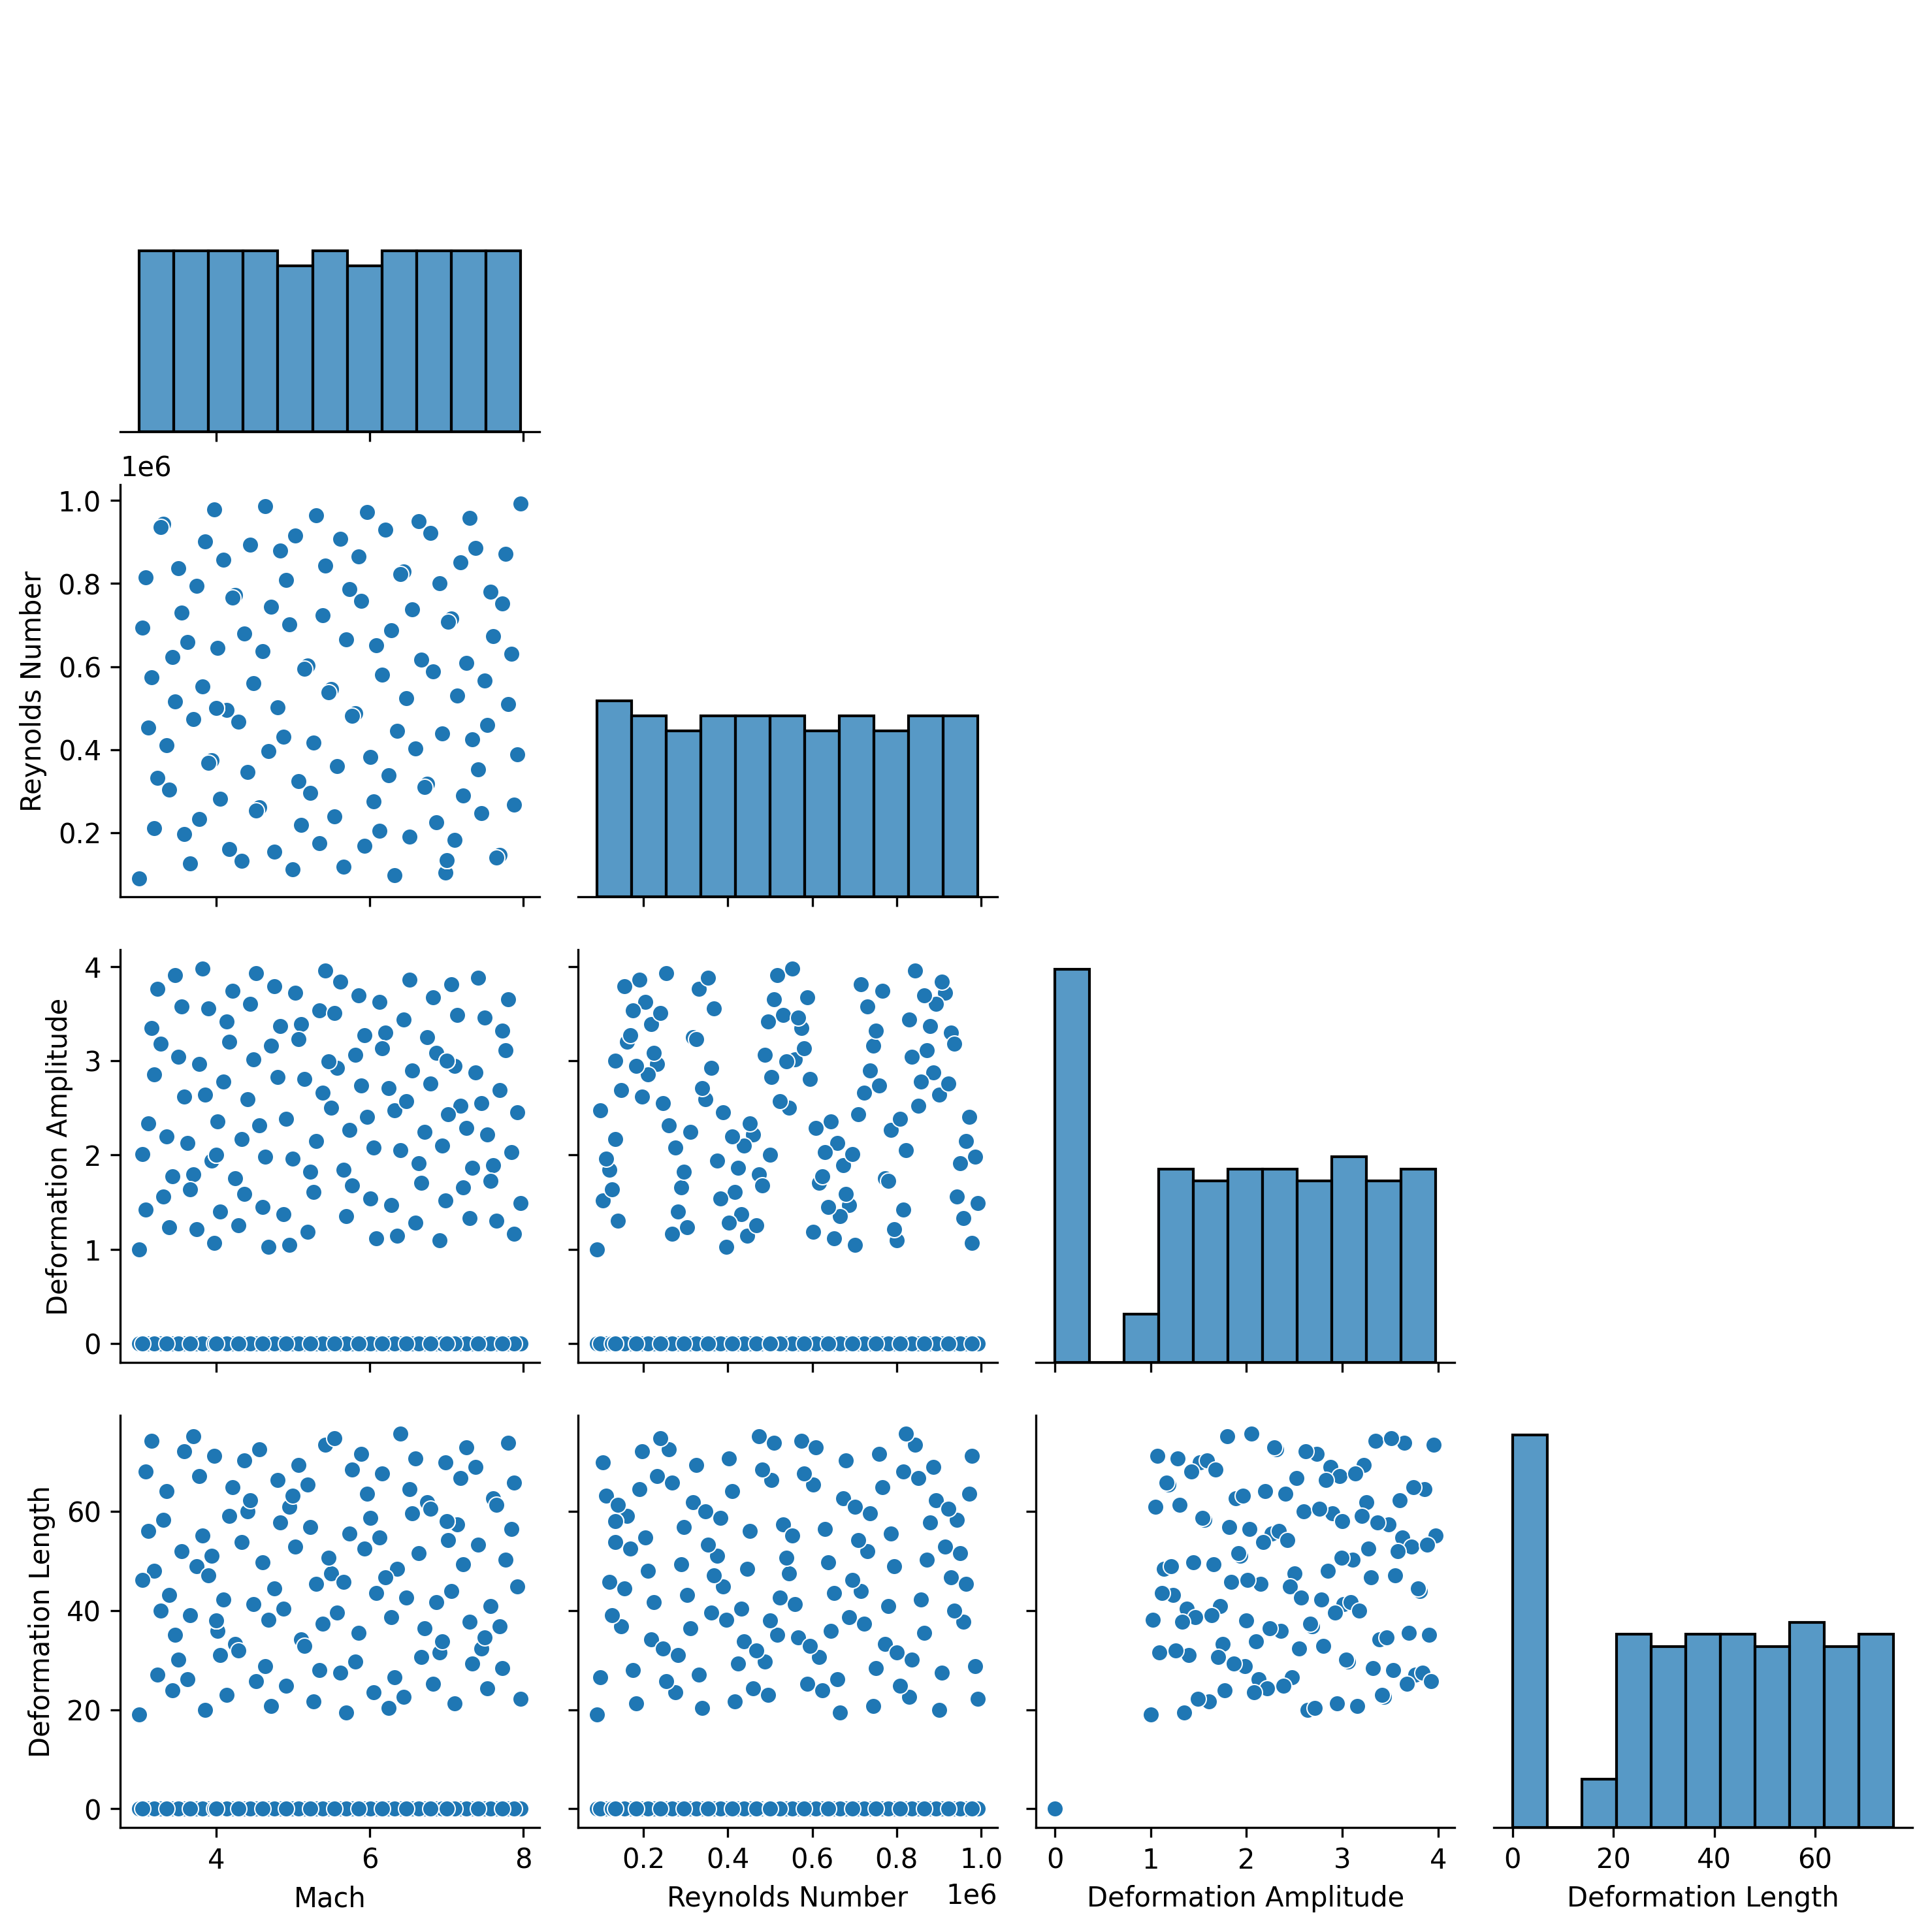

In [8]:
# # locationFromFlareDF = pd.DataFrame(data = sampleArray[:,locationOfLengthFromFlare])
# # sns.histplot(locationFromFlareDF)
# # sns.set(font_scale=1)
# selectedVariables = ['mach', 'reynolds', 'deformationAmplitude', 'deformationLength']

# columnRenameDict = {
#     'mach': 'Mach',
#     'reynolds': 'Reynolds Number',
#     'deformationAmplitude': 'Deformation Amplitude',
#     'deformationLength': 'Deformation Length'
# }

# df_new = df[selectedVariables]
# df_new = df_new.rename(columns=columnRenameDict)
# sns.pairplot(df_new, corner=True)

In [32]:
mat = scipy.io.loadmat('defslopecurv.mat')

def removekey(d, key):
    r = dict(d)
    del r[key]
    return r

delKeysList = ['__header__', '__version__', '__globals__']
for key in delKeysList:
    mat = removekey(mat,key)
    
columnNames = [keyname for keyname in mat.keys()]

In [45]:
aaronDict = {}
for key in mat.keys():
    aaronDict[key] = mat[key].reshape(-1,)
    # print(aaronDict[key].shape)
aaronDF = pd.DataFrame.from_dict(aaronDict)

In [50]:
aaronDF.keys()

Index(['maxcurv1', 'maxcurv1location', 'maxcurv2', 'maxcurv2location',
       'maxdef', 'maxdeflocation', 'maxslope1', 'maxslope1location',
       'maxslope2', 'maxslope2location', 'mincurv1', 'mincurv1location',
       'mincurv2', 'mincurv2location', 'mindef', 'mindeflocation', 'minslope1',
       'minslope1location', 'minslope2', 'minslope2location'],
      dtype='object')

In [67]:
concatDF = pd.concat([aaronDF,df],axis=1)
# concatDF.shape

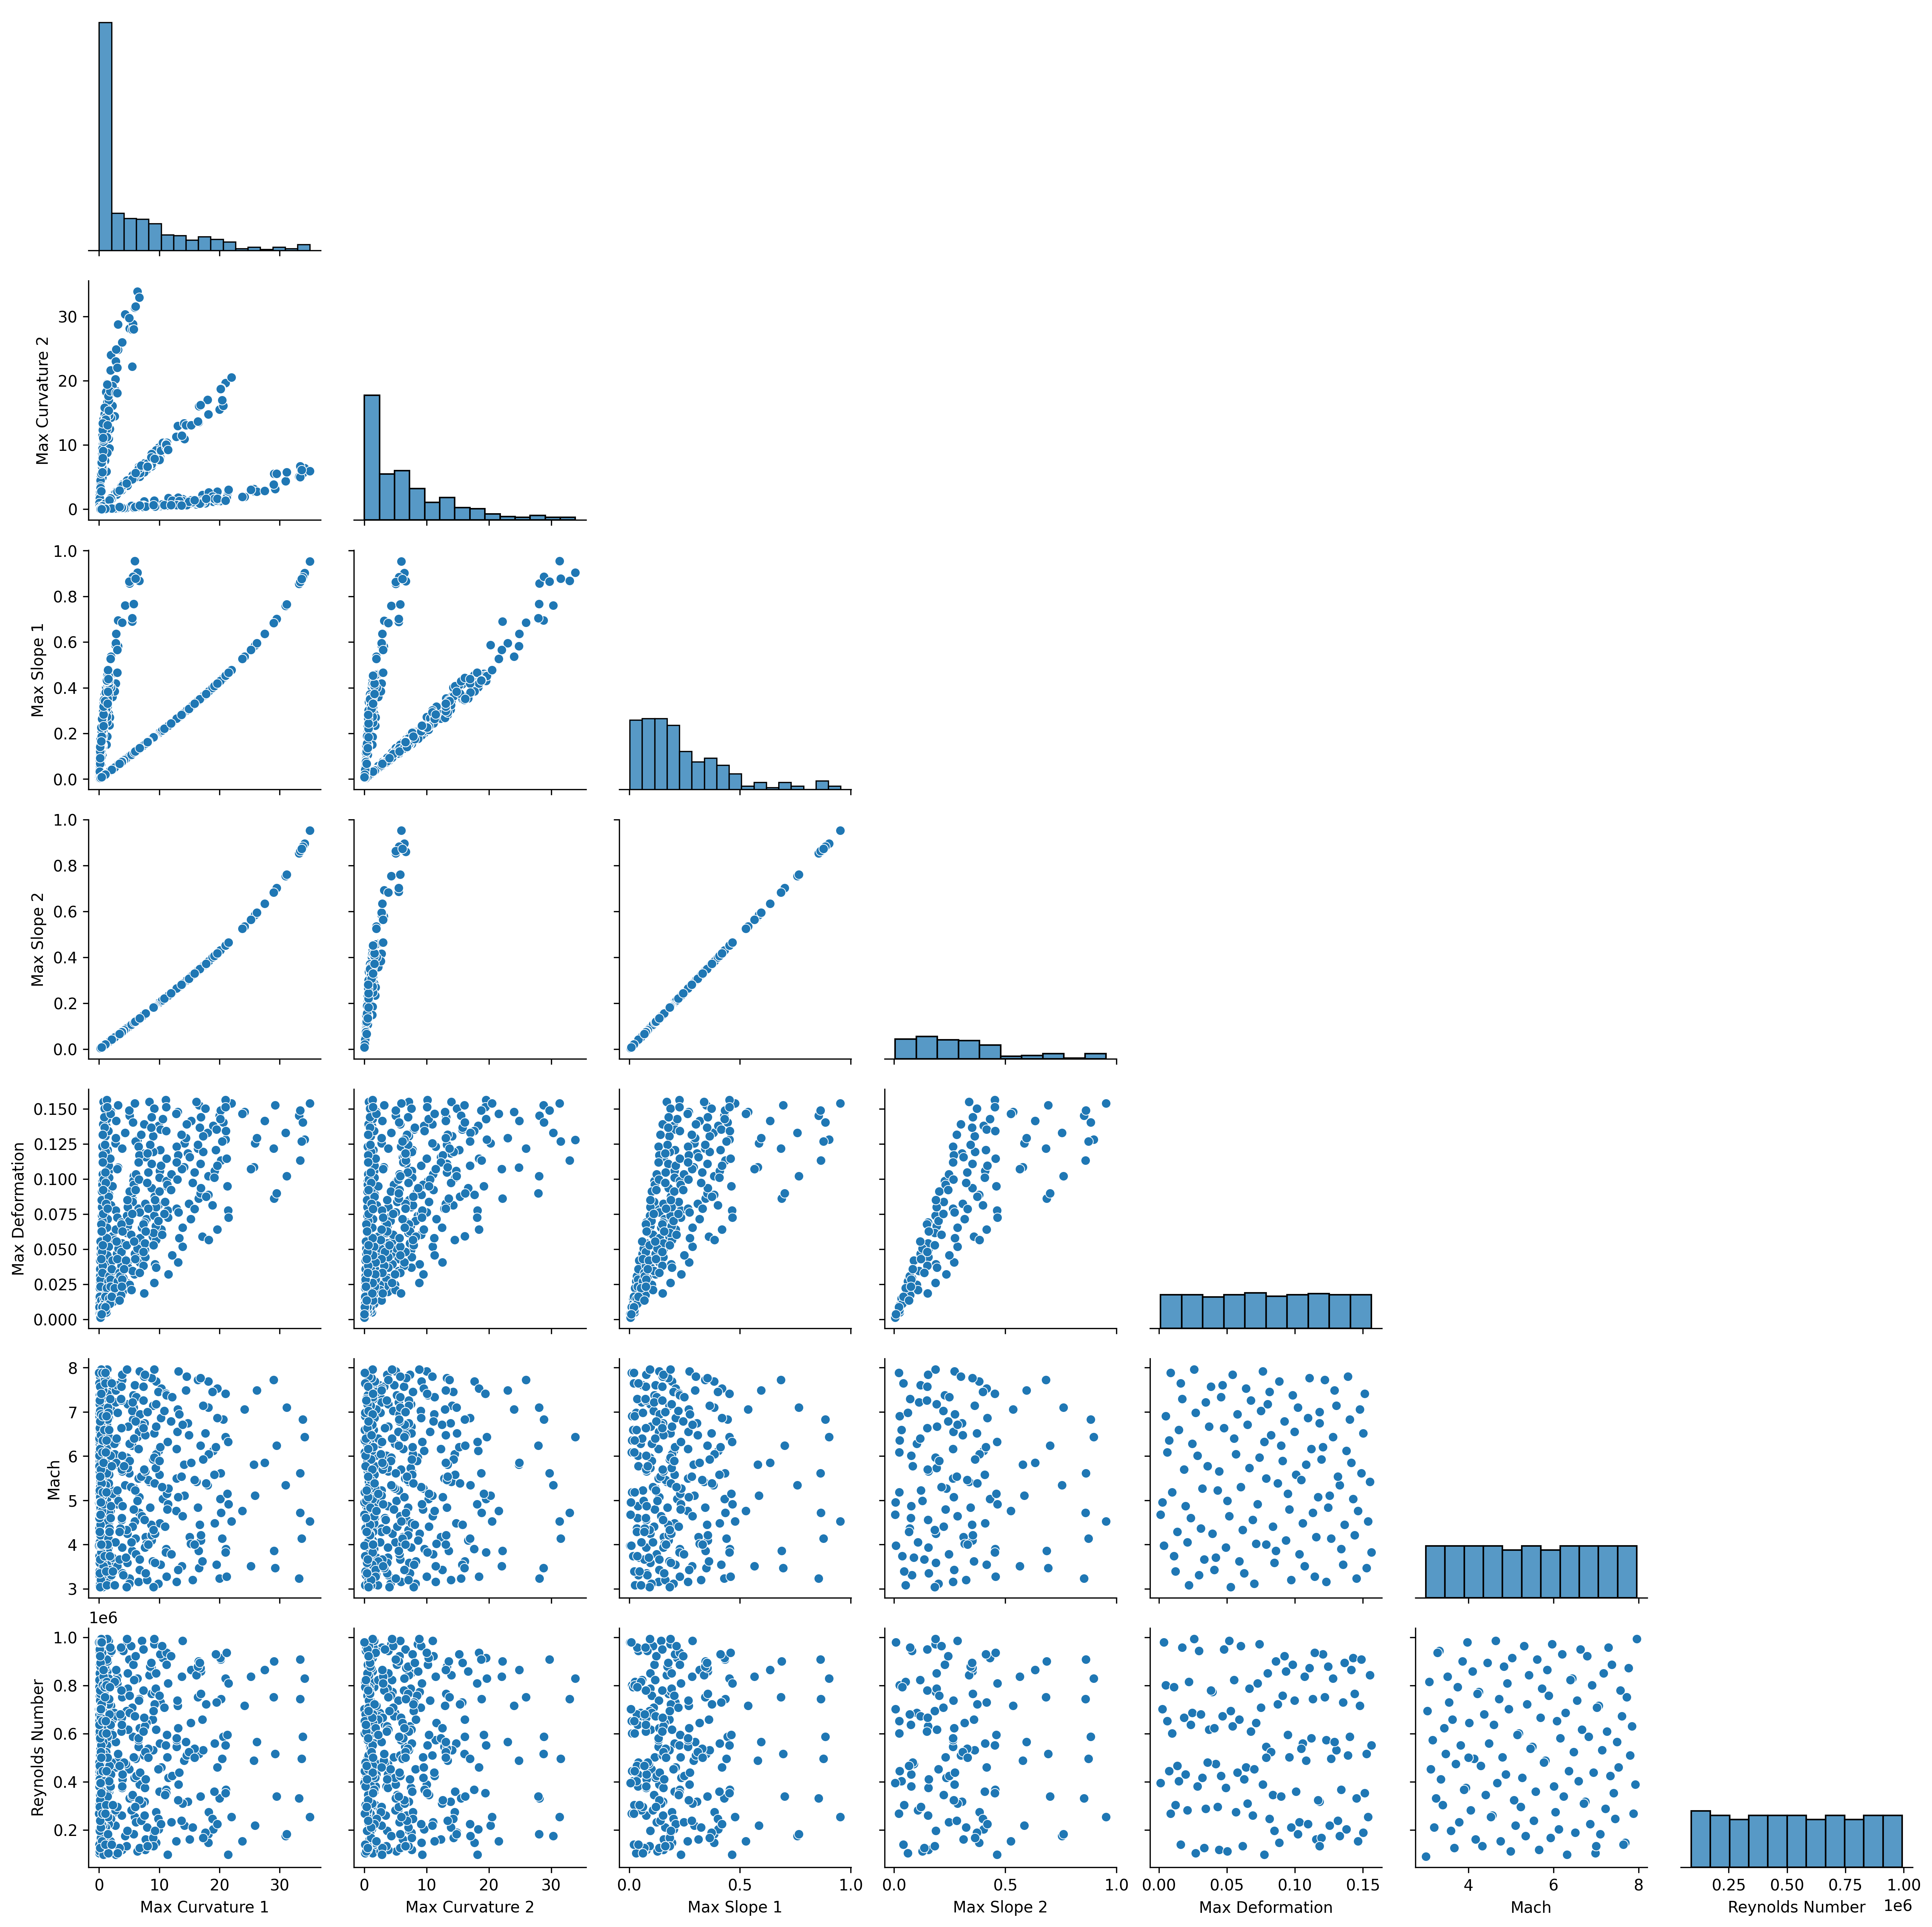

In [68]:
selectedVariables = ['maxcurv1', 'maxcurv2', 'maxslope1', 'maxslope2', 'maxdef', 'mach', 'reynolds']

columnRenameDict = {
    'maxcurv1': 'Max Curvature 1', 
    'maxcurv2': "Max Curvature 2", 
    'maxslope1': 'Max Slope 1', 
    'maxslope2': 'Max Slope 2',
    'maxdef': 'Max Deformation',
    'mach': 'Mach',
    'reynolds': 'Reynolds Number'
}

df_new = concatDF[selectedVariables]
df_new = df_new.rename(columns=columnRenameDict)
sns.pairplot(df_new, corner=True)